# Persistent homology of TPMS

In [59]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gudhi as gd
from gudhi.representations import Landscape
from gudhi.representations.vector_methods import Entropy

import json

## Read data

In [2]:
Gyroid_path = os.getcwd() + '/data/Gyroid/'
Schwarz_path = os.getcwd() + '/data/Schwarz_p/'

def get_number_of_point_cloud(filename):
    return int(re.findall(r'\d+', filename)[0])
    
pointcloud_dict_Gyroid = {get_number_of_point_cloud(filename): 
                          np.genfromtxt(Gyroid_path+filename, delimiter=',') for filename in os.listdir(Gyroid_path)}
pointcloud_dict_Schwarz = {get_number_of_point_cloud(filename): 
                           np.genfromtxt(Schwarz_path+filename, delimiter=',') for filename in os.listdir(Schwarz_path)}

porosity_df = pd.read_csv('linear_dependency.csv')

In [120]:
porosity_df.head(1)

,d_param,porosity_Schwarz_p,porosity_Gyroid
0,-0.985086,0.796602,0.806768


In [3]:
SIZE = 20
NUMBER_OF_POINTS = 1000

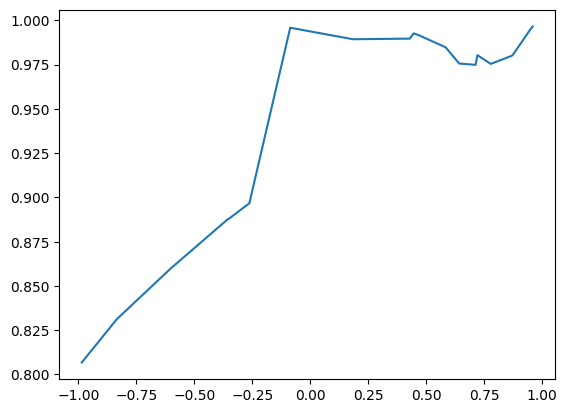

In [4]:
plt.plot(porosity_df['d_param'], porosity_df['porosity_Gyroid'])

## Plot functions

In [5]:
def plot_diagram_giotto(diagram, homology_dimensions=None, plotly_params=None):
    """Plot a single persistence diagram.

    Parameters
    ----------
    diagram : ndarray of shape (n_points, 3)
        The persistence diagram to plot, where the third dimension along axis 1
        contains homology dimensions, and the first two contain (birth, death)
        pairs to be used as coordinates in the two-dimensional plot.

    homology_dimensions : list of int or None, optional, default: ``None``
        Homology dimensions which will appear on the plot. If ``None``, all
        homology dimensions which appear in `diagram` will be plotted.

    plotly_params : dict or None, optional, default: ``None``
        Custom parameters to configure the plotly figure. Allowed keys are
        ``"traces"`` and ``"layout"``, and the corresponding values should be
        dictionaries containing keyword arguments as would be fed to the
        :meth:`update_traces` and :meth:`update_layout` methods of
        :class:`plotly.graph_objects.Figure`.

    Returns
    -------
    fig : :class:`plotly.graph_objects.Figure` object
        Figure representing the persistence diagram.

    """
    # TODO: increase the marker size
    if homology_dimensions is None:
        homology_dimensions = np.unique(diagram[:, 2])

    diagram = diagram[diagram[:, 0] != diagram[:, 1]]
    diagram_no_dims = diagram[:, :2]
    posinfinite_mask = np.isposinf(diagram_no_dims)
    neginfinite_mask = np.isneginf(diagram_no_dims)
    max_val = np.max(np.where(posinfinite_mask, -np.inf, diagram_no_dims))
    min_val = np.min(np.where(neginfinite_mask, np.inf, diagram_no_dims))
    parameter_range = max_val - min_val
    extra_space_factor = 0.02
    has_posinfinite_death = np.any(posinfinite_mask[:, 1])
    if has_posinfinite_death:
        posinfinity_val = max_val + 0.1 * parameter_range
        extra_space_factor += 0.1
    extra_space = extra_space_factor * parameter_range
    min_val_display = min_val - extra_space
    max_val_display = max_val + extra_space

    fig = gobj.Figure()
    fig.add_trace(gobj.Scatter(
        x=[min_val_display, max_val_display],
        y=[min_val_display, max_val_display],
        mode="lines",
        line={"dash": "dash", "width": 1, "color": "black"},
        showlegend=False,
        hoverinfo="none"
        ))

    for dim in homology_dimensions:
        name = f"H{int(dim)}" if dim != np.inf else "Any homology dimension"
        subdiagram = diagram[diagram[:, 2] == dim]
        unique, inverse, counts = np.unique(
            subdiagram, axis=0, return_inverse=True, return_counts=True
            )
        hovertext = [
            f"{tuple(unique[unique_row_index][:2])}" +
            (
                f", multiplicity: {counts[unique_row_index]}"
                if counts[unique_row_index] > 1 else ""
            )
            for unique_row_index in inverse
            ]
        y = subdiagram[:, 1]
        if has_posinfinite_death:
            y[np.isposinf(y)] = posinfinity_val
        fig.add_trace(gobj.Scatter(
            x=subdiagram[:, 0], y=y, mode="markers",
            hoverinfo="text", hovertext=hovertext, name=name
        ))

    fig.update_layout(
        width=500,
        height=500,
        xaxis1={
            "title": "Birth",
            "side": "bottom",
            "type": "linear",
            "range": [min_val_display, max_val_display],
            "autorange": False,
            "ticks": "outside",
            "showline": True,
            "zeroline": True,
            "linewidth": 1,
            "linecolor": "black",
            "mirror": False,
            "showexponent": "all",
            "exponentformat": "e"
            },
        yaxis1={
            "title": "Death",
            "side": "left",
            "type": "linear",
            "range": [min_val_display, max_val_display],
            "autorange": False, "scaleanchor": "x", "scaleratio": 1,
            "ticks": "outside",
            "showline": True,
            "zeroline": True,
            "linewidth": 1,
            "linecolor": "black",
            "mirror": False,
            "showexponent": "all",
            "exponentformat": "e"
            },
        plot_bgcolor="white"
        )

    # Add a horizontal dashed line for points with infinite death
    if has_posinfinite_death:
        fig.add_trace(gobj.Scatter(
            x=[min_val_display, max_val_display],
            y=[posinfinity_val, posinfinity_val],
            mode="lines",
            line={"dash": "dash", "width": 0.5, "color": "black"},
            showlegend=True,
            name=u"\u221E",
            hoverinfo="none"
        ))

    # Update traces and layout according to user input
    if plotly_params:
        fig.update_traces(plotly_params.get("traces", None))
        fig.update_layout(plotly_params.get("layout", None))

    return fig

In [6]:
def gudhi_dgm_to_giotto(dgm):
    """
    Transforms Gudhi diagram to Giotto-TDA diagram representation
    """
    size = len(dgm)
    giotto_dgm = np.zeros((size,3))
    homologies = np.array([cycle[0] for cycle in dgm])
    giotto_dgm[:,-1] = homologies
    birth_death_info = np.array([cycle[1] for cycle in dgm])
    giotto_dgm[:,:-1] = birth_death_info
    return giotto_dgm

## Persistence of Schwarz TPMS

In [68]:
Vectorizer=Landscape(num_landscapes=2,resolution=10)
Scalarizer = Entropy()

dgms = {}
dgms_0 = {}
vectorized_dgms_0 = {}
dgms_1 = {}
#vectorized_dgms_1 = {}
dgms_2 = {}
#vectorized_dgms_2 = {}
entropies_1 = {}
entropies_2 = {}

for i, pc in pointcloud_dict_Schwarz.items():
    print(f"{i}-th data is used for PH now")
    ac = gd.AlphaComplex(points=pc)
    stree = ac.create_simplex_tree()
    dgm = stree.persistence()
    entropies_1[i] = Scalarizer.fit_transform([stree.persistence_intervals_in_dimension(1)])
    entropies_2[i] = Scalarizer.fit_transform([stree.persistence_intervals_in_dimension(2)])
    #vectorized_dgms_1[i] = Vectorizer.fit_transform([stree.persistence_intervals_in_dimension(1)])
    #vectorized_dgms_2[i] = Vectorizer.fit_transform([stree.persistence_intervals_in_dimension(2)])
    #dgms[i] = dgm
    #dgms_0[i] = stree.persistence_intervals_in_dimension(0)
    #dgms_1[i] = stree.persistence_intervals_in_dimension(1)
    #dgms_2[i] = stree.persistence_intervals_in_dimension(2)

7-th data is used for PH now
6-th data is used for PH now
4-th data is used for PH now
5-th data is used for PH now
1-th data is used for PH now
0-th data is used for PH now
18-th data is used for PH now
2-th data is used for PH now
3-th data is used for PH now
19-th data is used for PH now
14-th data is used for PH now
15-th data is used for PH now
17-th data is used for PH now
16-th data is used for PH now
12-th data is used for PH now
8-th data is used for PH now
9-th data is used for PH now
13-th data is used for PH now
11-th data is used for PH now
10-th data is used for PH now


In [56]:
vectorized_dgms_0

{}

/Users/snopoff/miniconda3/envs/tpms/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:85: UserWarning: There are 1437165 intervals given as input, whereas max_intervals is set to 1000000.
  warnings.warn(
/Users/snopoff/miniconda3/envs/tpms/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:85: UserWarning: There are 1344325 intervals given as input, whereas max_intervals is set to 1000000.
  warnings.warn(
/Users/snopoff/miniconda3/envs/tpms/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:85: UserWarning: There are 1351780 intervals given as input, whereas max_intervals is set to 1000000.
  warnings.warn(
/Users/snopoff/miniconda3/envs/tpms/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:85: UserWarning: There are 1315659 intervals given as input, whereas max_intervals is set to 1000000.
  warnings.warn(
/Users/snopoff/miniconda3/envs/tpms/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:85: UserWarnin

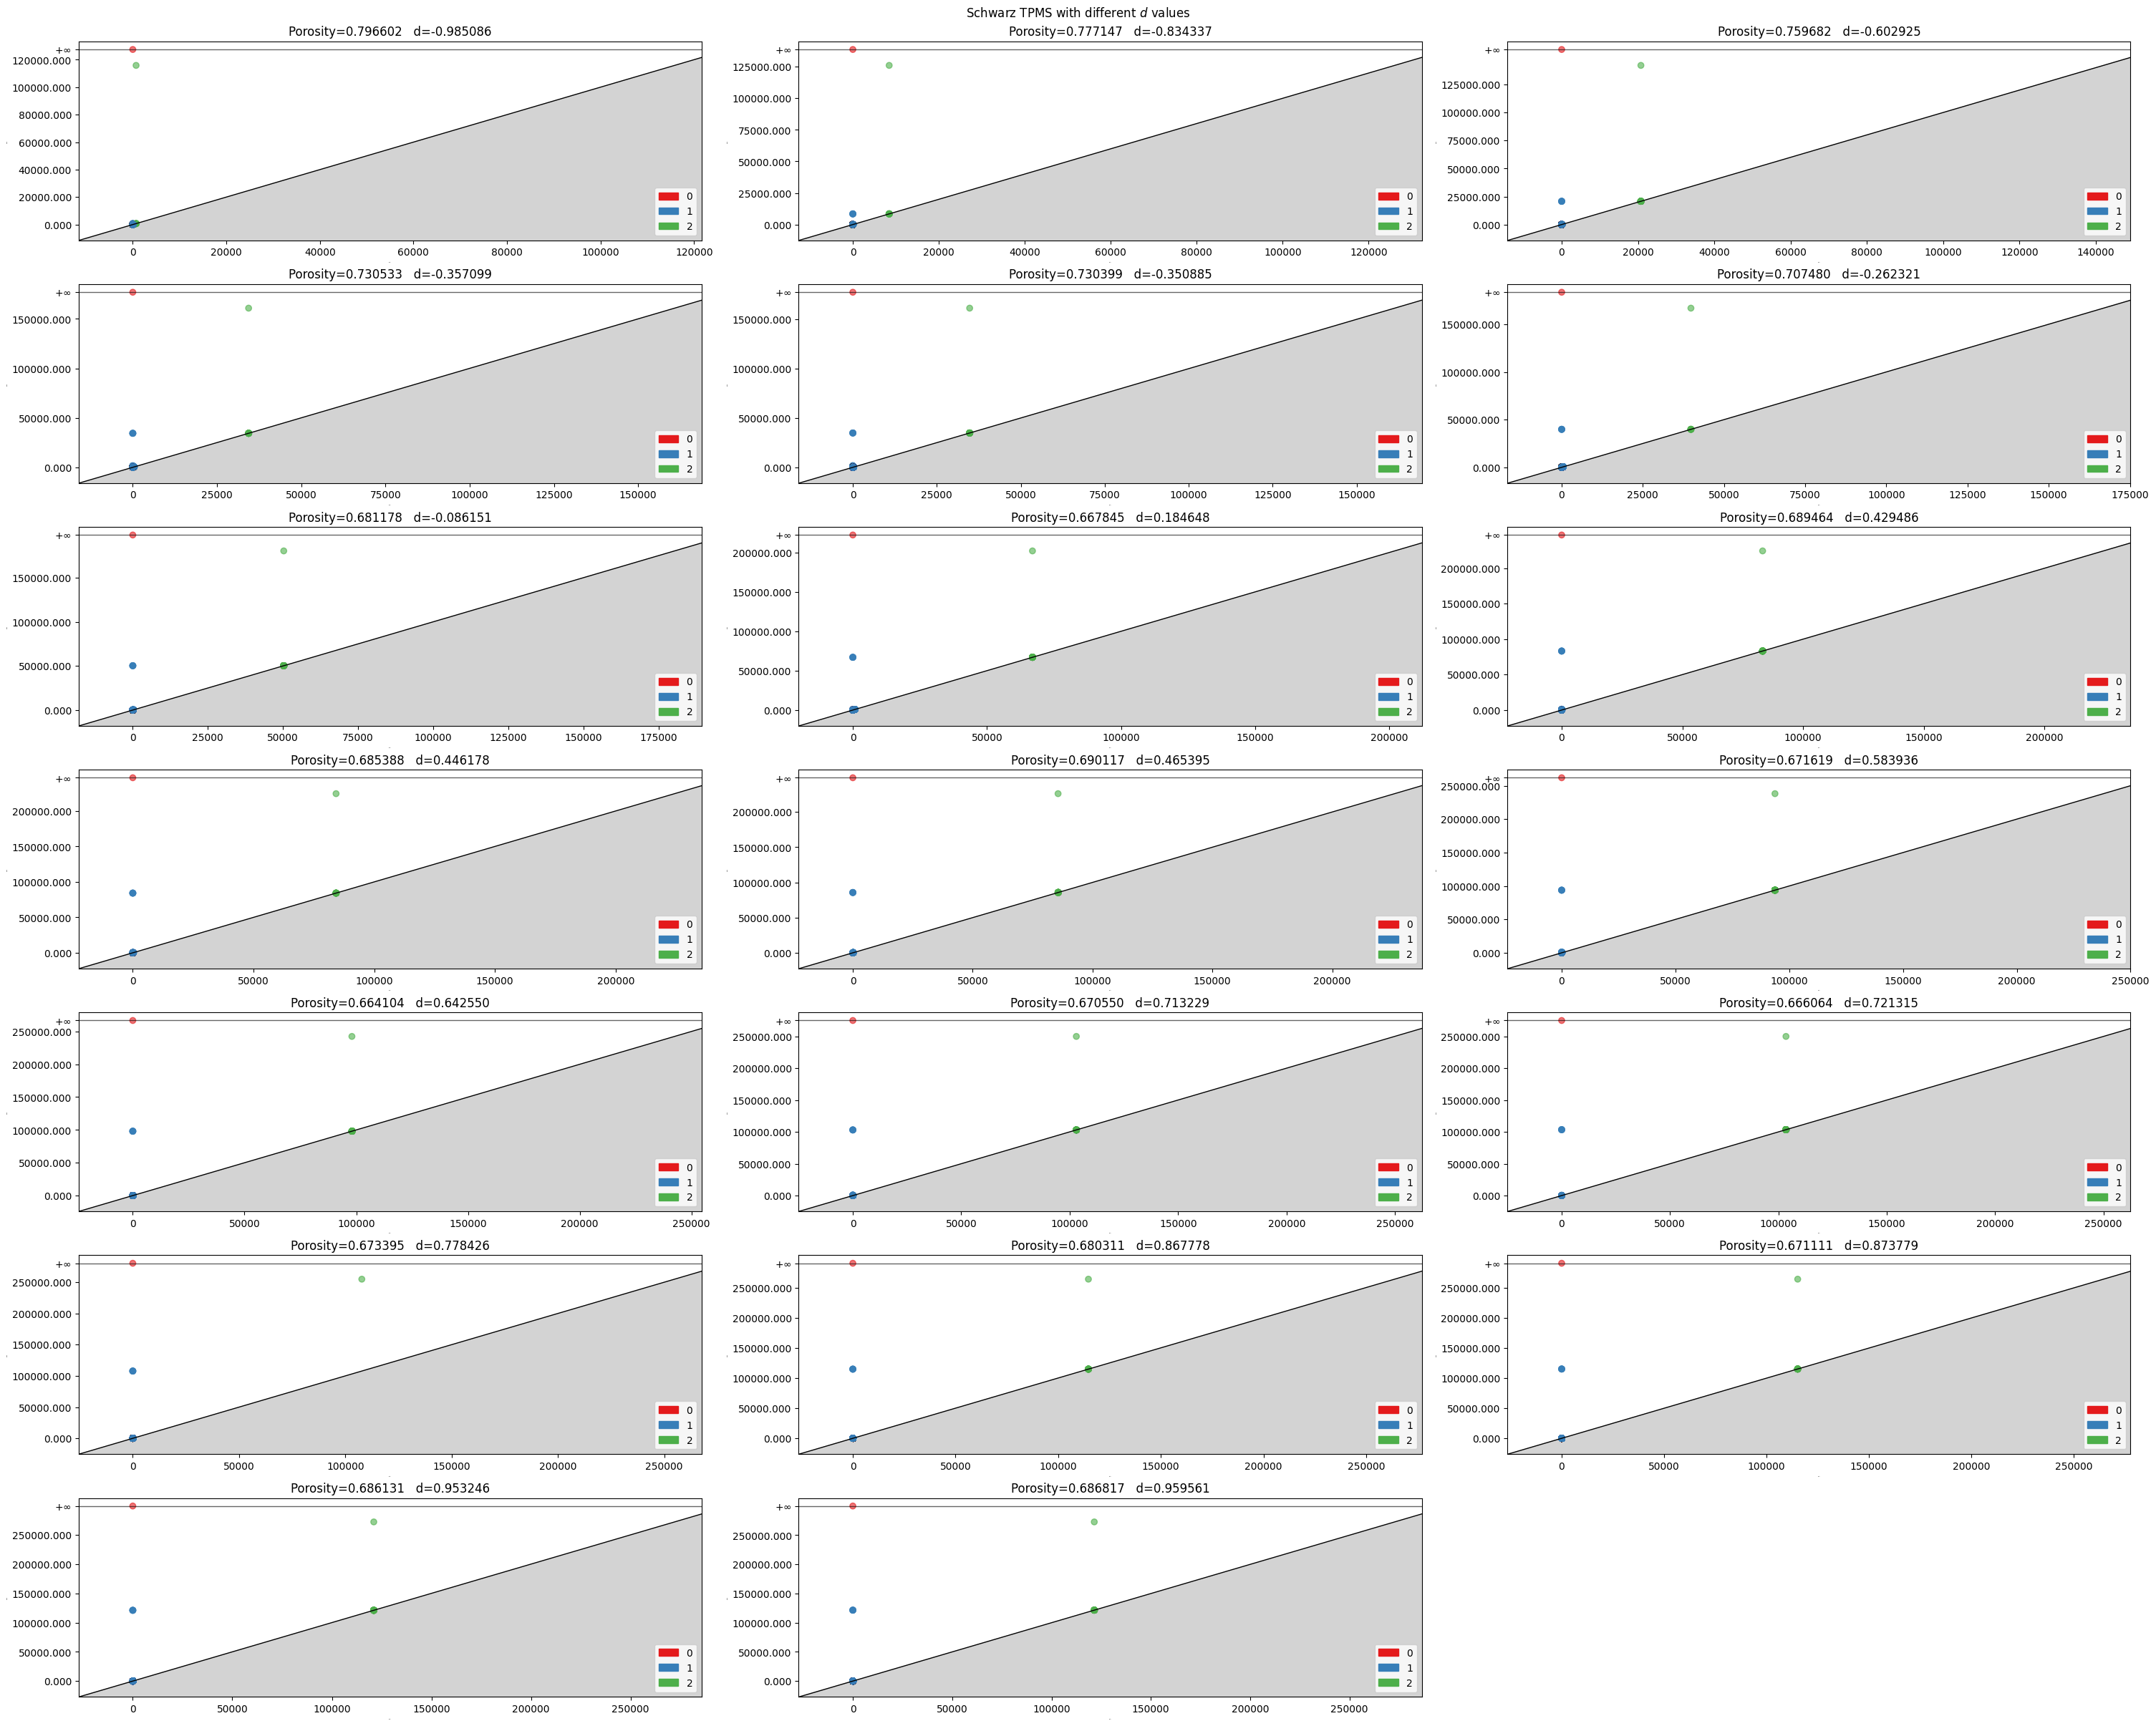

In [16]:
fig, axes = plt.subplots(figsize=(30,24), ncols=3, nrows=7, constrained_layout=True)
axes = axes.flatten()
for i in range(SIZE):
    gd.plot_persistence_diagram(dgms[i], axes=axes[i], fontsize=0)
    axes[i].set_title(f"Porosity={porosity_df['porosity_Schwarz_p'][i]:f}   d={porosity_df['d_param'][i]:f}")

[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]

fig.suptitle('Schwarz TPMS with different $d$ values')
fig.savefig('Schwarz_pd_per_porosity_size_10.png')
plt.show()

## Misc

In [ ]:
fig, axes = plt.subplots(figsize=(30,9), ncols=5, nrows=4, constrained_layout=True)
axes = axes.flatten()
for i in range(SIZE):
    gd.plot_persistence_diagram(dgms_0[i], axes=axes[i], fontsize=0)
    axes[i].set_title(f"Porosity={porosity_dict_Schwarz[i]:f}   d={d_param_dict[i]:f}")

fig.savefig('Schwarz_pd_0_dim_per_porosity_size_10.png')
fig.suptitle('Schwarz TPMS with different $d$ values. Only 0-dimensional PDs')
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(30,9), ncols=5, nrows=4, constrained_layout=True)
axes = axes.flatten()
for i in range(SIZE):
    gd.plot_persistence_diagram(dgms_2[i], axes=axes[i], fontsize=0)
    axes[i].set_title(f"Porosity={porosity_dict_Schwarz[i]:f}   d={d_param_dict[i]:f}")

fig.savefig('Schwarz_pd_2_dim_per_porosity_size_10.png')
fig.suptitle('Schwarz TPMS with different $d$ values. Only 2-dimensional PDs')
plt.show()

## Models
Let's try to learn some models to predict either persistence or porosity via the following data:
 - shape factor
 - porosity
 - persistent landscapes
 - persistence entropy

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt

### Use shape factor to predict entropy
1-entropy is nice: `degree=3` or `degree=4`

2-entropy is bad.

In [262]:
degree = 3

x = porosity_df['d_param'].values.reshape(-1,1)
x_poly = PolynomialFeatures(degree=degree).fit_transform(x)
x_poly.shape

(20, 4)

In [263]:
y_1 = np.array([entropies_1[i][0] for i in range(20)])
y_2 = np.array([entropies_2[i][0] for i in range(20)])
y_1.shape

(20, 1)

In [264]:
linear = LinearRegression()
linear.fit(x_poly, y_1)
y_pred = linear.predict(x_poly)
mse(y_1, y_pred)

0.0041678730657450066

In [265]:
print(f"coefficients are {linear.coef_}")

coefficients are [[ 0.         -2.9849738   1.17881158 -1.01308866]]


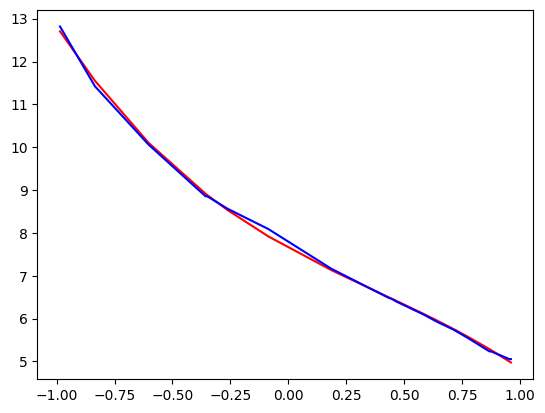

In [266]:
plt.plot(x, y_pred, c='red')
plt.plot(x, y_1, c='blue')

### Using `np.polyfit` to fit 1-entropy
I suppose that entropy is exponentially decaying in fact. To check it, let's polyfit shape factor and $log{(\text{1-entropy})}$


In [278]:
#fit the model
x = x.squeeze()
exponential_fit = np.polyfit(x, np.log(y_1), 2)

#view the output of the model
print(exponential_fit)

[[ 0.02566328]
 [-0.45120541]
 [ 2.04445919]]


In [281]:
exp_model =np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
mse(y_1, exp_model)

0.023703962197357577

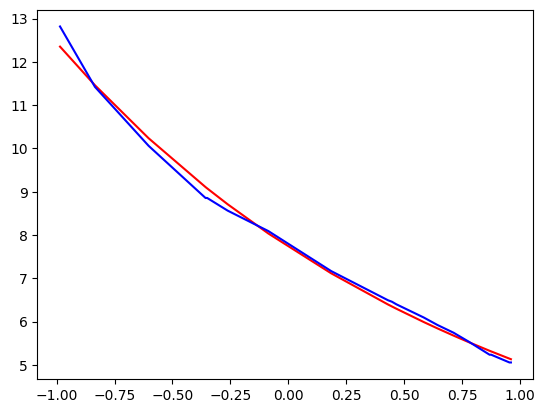

In [280]:
plt.plot(x, exp_model, c='red')
plt.plot(x, y_1, c='blue')

### Use entropy to predict porosity

In [156]:
degree = 4

x = np.array([entropies_1[i][0] for i in range(20)])
y = porosity_df['porosity_Schwarz_p'].values.reshape(-1,1)

In [157]:
linear = LinearRegression()
linear.fit(x_poly, y)
y_pred = linear.predict(x_poly)
mse(y_2, y_pred)

0.4681187627813637

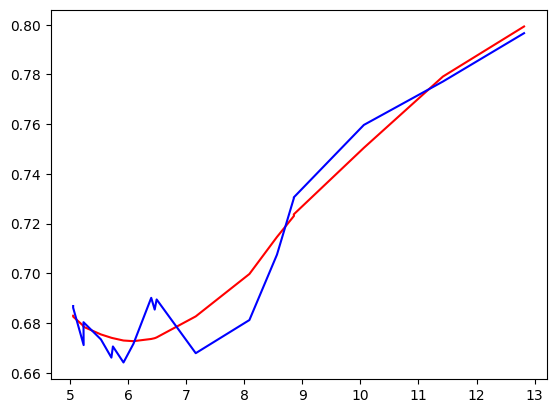

In [158]:
plt.plot(x, y_pred, c='red')
plt.plot(x, y, c='blue')

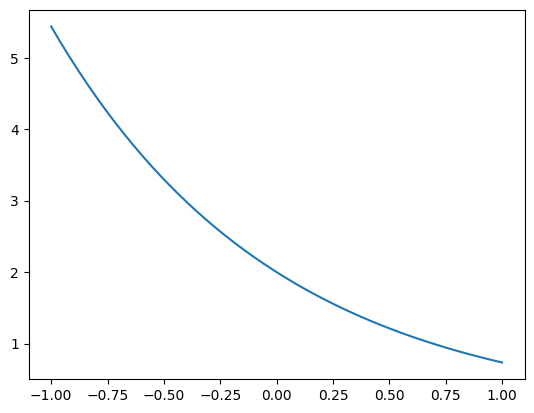

In [254]:
x = np.linspace(-1,1)
y = 2 * np.exp(-x)
plt.plot(x,y)